In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import psython as psy
import pingouin as pg
from scipy.stats import contingency 
from scipy.stats import levene

# Before the analyses

In [3]:
df_original = pd.read_csv("group23_alltogether.csv")
df = df_original.drop(df_original[df_original['userid'] < 584].index) # remove test data


# Exploratory analyses

In [4]:
# See how many people in each group
df['condition'].value_counts(sort=False)

condition
0    26
1    12
Name: count, dtype: int64

In [8]:
# frequencies of 
df['gender'].value_counts(sort=False)

gender
1.0    29
2.0     5
3.0     1
0.0     3
Name: count, dtype: int64

In [9]:
# descriptives of age  
df['leeftijd'].describe()

count    38.000000
mean     22.526316
std       5.838997
min      18.000000
25%      20.000000
50%      21.000000
75%      22.750000
max      52.000000
Name: leeftijd, dtype: float64

In [10]:
df['vega'].value_counts(sort=False)

vega
0.0    31
1.0     7
Name: count, dtype: int64

In [11]:
df['gluten'].value_counts(sort=False)

gluten
0.0    37
1.0     1
Name: count, dtype: int64

In [12]:
df['diabetes'].value_counts(sort=False)

diabetes
0.0    37
1.0     1
Name: count, dtype: int64

In [13]:
df['religion'].value_counts(sort=False)

religion
0.0    36
1.0     2
Name: count, dtype: int64

In [14]:
df['other'].value_counts(sort=False)

other
Nut / peanut allergy     1
FODMAP                   1
no coriander             1
Name: count, dtype: int64

In [15]:
df['opleiding'].value_counts(sort=False)

opleiding
2.0    19
5.0     9
4.0     5
6.0     3
3.0     2
Name: count, dtype: int64

# Defining functions to be re-used
Here I add another layer of abstraction so I can more easily run the analyses once I actually have the data

The functions are based on or inspired by: https://github.com/uvacw/teaching-ds-rp/blob/ace3c716a4cfc18809d9203bfc73009f1233a311/week3/analyzing-experiments.ipynb

## Rank-sum test (as non-parametric alternative to ttest)

In [16]:
def rank_sum_test(df, 
                  grouping_variable: str, 
                  group_1: str,
                  group_2: str,
                  dv: str,
                  alternative: str = "two-sided"): # define the standard arguments of the function

    (label1, values1), (label2, values2) = df.groupby(grouping_variable)[dv]
    
    testresult = pg.mwu(values1, values2, alternative=alternative)

    print(f"{label1} M: {np.mean(values1):.2f} \n{label2} M: {np.mean(values2):.2f}")
    print(f"{label1} Mdn: {np.median(values1):.2f} \n{label2} Mdn: {np.median(values2):.2f}")

    print(testresult)
    return testresult

## Chi-square

In [17]:
def chi_square(
    df, 
    rows: str, 
    columns: str,
    test_association: bool = True,
    method_association: str = "cramer"
):
    mycrosstab = pd.crosstab(df[rows], df[columns])
    
    
    # and then get the chi2 test for that table
    c, p, dof, expected = contingency.chi2_contingency(mycrosstab)
    print(f"𝜒²({dof:.0f}) = {c:.3f}, p = {p:.3f} ")
    
    # maybe Cramer's V as well?
    if test_association:
        print(f"Association = {contingency.association(mycrosstab,method=method_association):.3f}")

    return mycrosstab


## Doing the actual tests

In [18]:
# setting standard values of the arguments
grouping_variable = "condition"
group_1 = "0"
group_2 = "1"
rows = "condition"


In [19]:
#rank-sum test age (randomisation check)
rank_sum_test(
    df=df,
    group_1=group_1,
    group_2=group_2,
    dv="leeftijd",
    grouping_variable=grouping_variable
)

0 M: 23.12 
1 M: 21.25
0 Mdn: 21.00 
1 Mdn: 21.00
     U-val alternative     p-val       RBC      CLES
MWU  161.5   two-sided  0.872877 -0.035256  0.517628


,U-val,alternative,p-val,RBC,CLES
MWU,161.5,two-sided,0.872877,-0.035256,0.517628


In [20]:
# chi-square randomisation checks

In [21]:
# gender
chi_square(
    df=df,
    columns="gender",
    rows=rows,
    
)

𝜒²(3) = 6.188, p = 0.103 
Association = 0.404


gender,0.0,1.0,2.0,3.0
condition,,,,
0,1,20,5,0
1,2,9,0,1


In [22]:
# education
chi_square(
    df=df,
    columns="opleiding",
    rows=rows,
    
)

𝜒²(4) = 2.265, p = 0.687 
Association = 0.244


opleiding,2.0,3.0,4.0,5.0,6.0
condition,,,,,
0,12,1,4,6,3
1,7,1,1,3,0


In [23]:
chi_square(
    df=df,
    columns="vega",
    rows=rows,
    
)

𝜒²(1) = 0.068, p = 0.794 
Association = 0.115


vega,0.0,1.0
condition,,
0,22,4
1,9,3


In [24]:
chi_square(
    df=df,
    columns="gluten",
    rows=rows,
    
)

𝜒²(1) = 0.161, p = 0.688 
Association = 0.242


gluten,0.0,1.0
condition,,
0,26,0
1,11,1


In [25]:
chi_square(
    df=df,
    columns="diabetes",
    rows=rows,
    
)

𝜒²(1) = 0.000, p = 1.000 
Association = 0.112


diabetes,0.0,1.0
condition,,
0,25,1
1,12,0


In [26]:
chi_square(
    df=df,
    columns="religion",
    rows=rows,
    
)

𝜒²(1) = 1.842, p = 0.175 
Association = 0.347


religion,0.0,1.0
condition,,
0,26,0
1,10,2


In [27]:
# define new column that has "0" if a participant did not fill out any 
# dietary restrictions under "other" and "1" else
df['other2'] = df['other'].apply(lambda x: '1' if pd.notnull(x) else '0')

In [28]:
chi_square(
    df=df,
    columns="other2",
    rows=rows,
    
)

𝜒²(1) = 0.335, p = 0.563 
Association = 0.199


other2,0,1
condition,,
0,23,3
1,12,0


In [29]:
# chi-square manipulation check

In [30]:
chi_square(
    df=df,
    columns="mancheck",
    rows=rows,
    
)

𝜒²(1) = 33.513, p = 0.000 
Association = 1.000


mancheck,0,1
condition,,
0,26,0
1,0,12


## Cronbach's alpha
For the dependent variable

In [31]:
items = df[['Q4','Q5','Q6']]

In [32]:
# Calculate the initial Cronbach's alpha
pg.cronbach_alpha(items)

(0.8627008250108554, array([0.765, 0.924]))

In [33]:
# calculate the alpha value without each item
alpha_deleted_items = []
for item in items.columns:
    reduced_data = items.drop(item, axis=1)
    alpha = pg.cronbach_alpha(reduced_data)
    alpha_deleted_items.append((item, alpha))

for item, alpha in alpha_deleted_items:
    print("Item removed:", item)
    print("Cronbach's alpha:", alpha)
    print()

Item removed: Q4
Cronbach's alpha: (0.78752332711277, array([0.591, 0.89 ]))

Item removed: Q5
Cronbach's alpha: (0.6706274074557681, array([0.366, 0.829]))

Item removed: Q6
Cronbach's alpha: (0.9337072112586635, array([0.872, 0.966]))



In [34]:
df['satisfaction'] = df[['Q4','Q5','Q6']].mean(axis=1) # construct the new variable

In [35]:
df['satisfaction'].describe() # get descriptives of the new variable

count    38.000000
mean      4.201754
std       1.652261
min       1.333333
25%       2.750000
50%       4.666667
75%       5.583333
max       6.666667
Name: satisfaction, dtype: float64

## Hypothesis testing

In [36]:
#rank sum test satisfaction
rank_sum_test(
    df=df,
    group_1=group_1,
    group_2=group_2,
    dv="satisfaction",
    grouping_variable=grouping_variable,
    alternative = "less" # because i test a one-sided hypothesis
)

0 M: 4.12 
1 M: 4.39
0 Mdn: 4.67 
1 Mdn: 4.83
     U-val alternative   p-val      RBC      CLES
MWU  137.5        less  0.2851  0.11859  0.559295


,U-val,alternative,p-val,RBC,CLES
MWU,137.5,less,0.2851,0.11859,0.559295


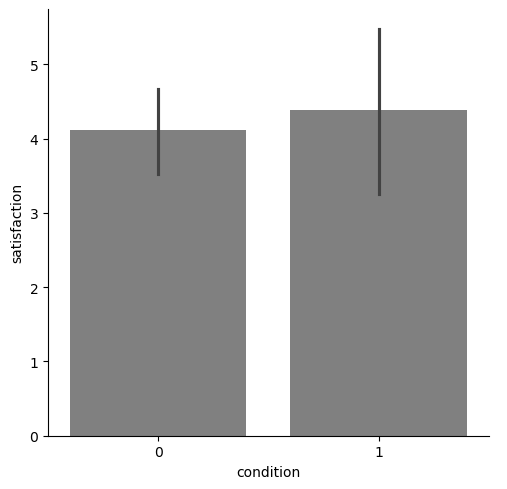

In [55]:
# visualisation
sns.catplot(x='condition', y='satisfaction', kind='bar', data=df, color="grey")